In [652]:
import pandas as pd
import numpy as np
import os
def load_dataset():
    """Loads the Iris dataset from a CSV file and preprocesses it."""
    def load_data(file_path):
        """Loads data from a CSV file and returns X (features) and y (one-hot encoded labels)."""
        try:
            df = pd.read_csv(file_path)
        except FileNotFoundError:
            raise FileNotFoundError(f"File not found: {file_path}")
        except Exception as e:
            raise Exception(f"Error while loading the file: {e}")
        
        X = df.drop(columns=['Id', 'Species'])
        y = one_hot_encoder(df['Species'])
        return X, y

    def one_hot_encoder(labels):
        """Converts labels to one-hot encoding."""
        unique_labels = np.unique(labels)
        label_to_index = {label: index for index, label in enumerate(unique_labels)}
        label_indices = np.array([label_to_index[label] for label in labels])
        return np.eye(len(unique_labels))[label_indices]

    def split_dataset(X, y, test_size=0.2, stratify=False):
        """Splits dataset into train and test sets, ensuring balanced class distribution if stratify=True."""
        if stratify:
            class_labels = np.argmax(y, axis=1)
            
            classes, class_counts = np.unique(class_labels, return_counts=True)
            train_indices, test_indices = [], []        
            
            for i, class_ in enumerate(classes):        
                class_indices = np.where(class_labels == class_)[0]
                np.random.shuffle(class_indices)

                num_test_samples = int(class_counts[i] * test_size)
                            
                test_class_indices = class_indices[:num_test_samples]
                train_class_indices = class_indices[num_test_samples:]
                
                test_indices.extend(test_class_indices)
                train_indices.extend(train_class_indices)
            
            train_indices = np.array(train_indices)
            test_indices = np.array(test_indices)
        
        else:        
            num_samples = len(y)
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            
            split_idx = int(num_samples * (1 - test_size))
            train_indices, test_indices = indices[:split_idx], indices[split_idx:]
        
        # Tworzymy zbiory X_train, X_test, y_train, y_test
        X_train, X_test = X.iloc[train_indices].values, X.iloc[test_indices].values
        y_train, y_test = y[train_indices], y[test_indices]
        
        return X_train, X_test, y_train, y_test

    def data_normalization(X):
        """Normalizes the dataset using Min-Max scaling."""
        return (X - X.min()) / (X.max() - X.min())

    def load_and_preprocess_data(file_path, test_size=0.2):
        """Loads and preprocesses data, returning train and test sets."""
        X, y = load_data(file_path)
        X = data_normalization(X)
        return split_dataset(X, y, test_size)

    file_path = os.path.join('data', 'raw', 'Iris.csv')
    X, y = load_data(file_path)
    X_normalize = data_normalization(X)

    X_train, X_test, y_train, y_test = split_dataset(X_normalize, y, test_size=0.2, stratify=True)
    return X_train, X_test, y_train, y_test, X, y

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def load_keras_iris_dataset():
    iris = load_iris()

    X = iris.data
    y = iris.target

    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    y_one_hot = np.eye(len(np.unique(y)))[y_encoded]

    # Przetasowanie danych przed podziałem
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    X, y_one_hot = X[indices], y_one_hot[indices]

    X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, stratify=y_one_hot)

    return X_train, X_test, y_train, y_test, X, y_one_hot


In [653]:
import numpy as np
import matplotlib.pyplot as plt

def train(X_train, y_train, X_test, y_test, epochs=230, learning_rate=0.01, batch_size=32, lr_scheduler=True, step_size=10, gamma=0.95):
    def relu(x):
        return np.maximum(0, x)

    def relu_derivative(x):
        return (x > 0).astype(float)

    def softmax(x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def softmax_derivative(output, y):
        return output - y

    input_size = X_train.shape[1]
    hidden_size_1 = 10
    hidden_size_2 = 8
    output_size = y_train.shape[1]

    np.random.seed(42)
    W1 = np.random.randn(input_size, hidden_size_1) * np.sqrt(2 / input_size)
    W2 = np.random.randn(hidden_size_1, hidden_size_2) * np.sqrt(2 / hidden_size_1)
    W3 = np.random.randn(hidden_size_2, output_size) * np.sqrt(2 / hidden_size_2)
    
    b1, b2, b3 = np.zeros((1, hidden_size_1)), np.zeros((1, hidden_size_2)), np.zeros((1, output_size))
    beta1, beta2, epsilon = 0.9, 0.999, 1e-8
    
    mW1, vW1, mb1, vb1 = np.zeros_like(W1), np.zeros_like(W1), np.zeros_like(b1), np.zeros_like(b1)
    mW2, vW2, mb2, vb2 = np.zeros_like(W2), np.zeros_like(W2), np.zeros_like(b2), np.zeros_like(b2)
    mW3, vW3, mb3, vb3 = np.zeros_like(W3), np.zeros_like(W3), np.zeros_like(b3), np.zeros_like(b3)
    
    loss_history, accuracy_history = [], []
    grad_norms = []
    
    for epoch in range(epochs):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train, y_train = X_train[indices], y_train[indices]
        
        epoch_loss, epoch_grad_norm = 0, 0
        
        for i in range(0, X_train.shape[0], batch_size):
            X_batch, y_batch = X_train[i:i+batch_size], y_train[i:i+batch_size]
            
            Z1, A1 = np.dot(X_batch, W1) + b1, relu(np.dot(X_batch, W1) + b1)
            Z2, A2 = np.dot(A1, W2) + b2, relu(np.dot(A1, W2) + b2)
            Z3, A3 = np.dot(A2, W3) + b3, softmax(np.dot(A2, W3) + b3)
            
            loss = -np.sum(y_batch * np.log(A3 + 1e-8)) / y_batch.shape[0]
            dZ3 = softmax_derivative(A3, y_batch)
            dW3, db3 = np.dot(A2.T, dZ3), np.sum(dZ3, axis=0, keepdims=True)
            
            dZ2 = np.dot(dZ3, W3.T) * relu_derivative(Z2)
            dW2, db2 = np.dot(A1.T, dZ2), np.sum(dZ2, axis=0, keepdims=True)
            
            dZ1 = np.dot(dZ2, W2.T) * relu_derivative(Z1)
            dW1, db1 = np.dot(X_batch.T, dZ1), np.sum(dZ1, axis=0, keepdims=True)
            
            epoch_grad_norm += np.linalg.norm(dW1) + np.linalg.norm(dW2) + np.linalg.norm(dW3)
            
            for param, dparam, m, v in zip([W1, W2, W3, b1, b2, b3],
                                           [dW1, dW2, dW3, db1, db2, db3],
                                           [mW1, mW2, mW3, mb1, mb2, mb3],
                                           [vW1, vW2, vW3, vb1, vb2, vb3]):
                m = beta1 * m + (1 - beta1) * dparam
                v = beta2 * v + (1 - beta2) * (dparam ** 2)
                m_hat, v_hat = m / (1 - beta1 ** (epoch + 1)), v / (1 - beta2 ** (epoch + 1))
                param -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
            
            epoch_loss += loss
        
        if lr_scheduler and epoch % step_size == 0 and epoch != 0:
            learning_rate *= gamma
            
        loss_history.append(epoch_loss / (X_train.shape[0] // batch_size))
        grad_norms.append(epoch_grad_norm)
        
        Z3_test = softmax(np.dot(relu(np.dot(relu(np.dot(X_train, W1) + b1), W2) + b2), W3) + b3)
        accuracy_history.append(np.mean(np.argmax(Z3_test, axis=1) == np.argmax(y_train, axis=1)))
    
    # Plot results
    fig, axs = plt.subplots(3, 1, figsize=(8, 10))
    axs[0].plot(loss_history, label='Loss')
    axs[0].set_title('Loss per Epoch')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    
    axs[1].plot(accuracy_history, label='Accuracy', color='green')
    axs[1].set_title('Accuracy per Epoch')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    
    axs[2].plot(grad_norms, label='Gradient Norm', color='red')
    axs[2].set_title('Gradient Norm per Epoch')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Gradient Norm')
    axs[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    return loss_history, accuracy_history, grad_norms

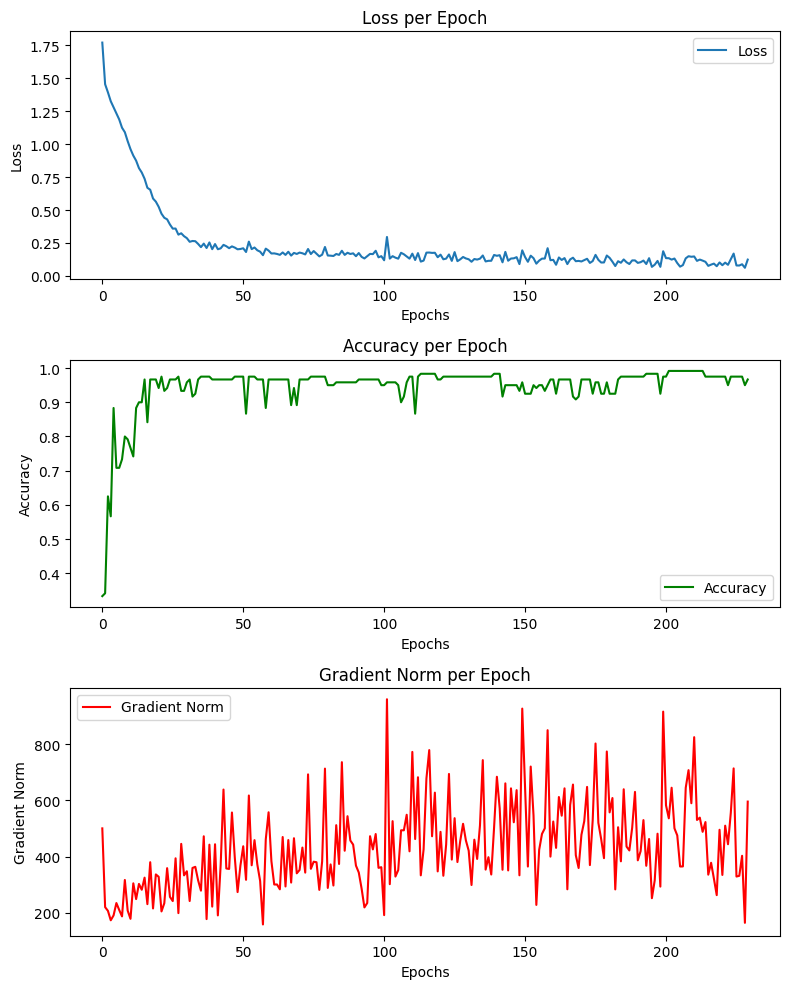

([1.769608749431227,
  1.4538380479728676,
  1.3921229073564998,
  1.325037645956183,
  1.278408047608482,
  1.2314546714100947,
  1.1867635842840276,
  1.1239695407502102,
  1.0900669430734813,
  1.0224043557660243,
  0.9618070318190606,
  0.9128067882257578,
  0.8743289173729732,
  0.8179993020875381,
  0.7843851040113882,
  0.7372463613052566,
  0.6685272889779842,
  0.6538207180885675,
  0.5872774312327745,
  0.5634122699819812,
  0.524519065795571,
  0.4720059263656869,
  0.4412224137290727,
  0.42941047974072766,
  0.390137595814911,
  0.3589333535019727,
  0.35954278250584487,
  0.3133361174898084,
  0.3235883049770207,
  0.30163931023231133,
  0.2867547424880862,
  0.2591502179077931,
  0.2650924065834259,
  0.2635796816854587,
  0.24293276044106293,
  0.21851887772989667,
  0.24523781102731843,
  0.21199609717329512,
  0.25412830525859825,
  0.2030811290656194,
  0.2418158197047857,
  0.20261096204474124,
  0.20946882223640037,
  0.23570746677046503,
  0.2254817694915506,
  0.

In [654]:
X_train, y_train, X_test, y_test, _, _ = load_keras_iris_dataset()
train(X_train, X_test, y_train, y_test, epochs=230, learning_rate=0.01, batch_size=32, lr_scheduler=True, step_size=10, gamma=0.95)